# CIFAR-10

In [1]:
import torch
from torchvision import datasets, transforms, models
import numpy as np
from matplotlib import pyplot as plt
import random
import argparse
from torch.utils.data import DataLoader, Subset, random_split
import os
import torch.nn as nn
import torch.optim as optim
from utils import plot_tsne
import torchvision
import torchvision.models as models

import Trainers
import autoencoders 
import classifiers as clf

/home/kerenmizrahi/miniconda3/envs/cs236781-hw/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/kerenmizrahi/miniconda3/envs/cs236781-hw/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


##### Load and prepare data

torch.Size([64, 3, 32, 32])


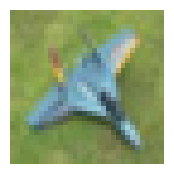

In [2]:
def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

freeze_seeds(42)

# normalize data 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


dataset_path = '/datasets/cv_datasets/data'
batch_size = 64

# Load CIFAR10 from the given path
ds_train = datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform)
ds_validation = datasets.CIFAR10(root=dataset_path, train=False, download=False, transform=transform)

# dataset split: 
# train + test (during training)
# validation

# Split  80% train  20% test
train_size = int(0.8 * len(ds_train))  
test_size = len(ds_train) - train_size  
ds_train, ds_test = random_split(ds_train, [train_size, test_size])

# DataLoaders
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_validation, batch_size=batch_size, shuffle=True)


# Example - [batch_size, 3, 32, 32]
for image, label in dl_train:
    print(image.shape)
    plt.figure(figsize=(2, 2)) 
    # Denormalize the image befor plt.imshow
    image = image * torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1) + torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1)
    img = image[0].permute(1, 2, 0)
    plt.imshow(img.cpu().numpy()) 
    plt.axis('off')  
    plt.show()

    break

## 1.2.1 

##### Initialize Autoencoder

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = autoencoders.Encoder_cifar10().to(device)
decoder = autoencoders.Decoder_cifar10().to(device)
#autoencoder_model = autoencoder.Autoencoder(encoder, decoder).to(device)


##### Train AutoEncoder (self-supervised)

In [ ]:
#loss_fn = nn.L1Loss() # MAE loss  - HAVE TO REPORT
loss_fn = nn.MSELoss()
#optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),  lr=0.001)
optimizer = optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()),  lr=0.001, weight_decay=1e-5)
num_epochs = 20 

trainer = Trainers.autoencoderTrainer(encoder, decoder, dl_train, dl_test, loss_fn, optimizer, num_epochs, device)
trainer.trainAutoencoder() 

# Adam, L1Loss lr=0.001, epochs=25 - 0.0948

Epoch 1:
    train reconstruction error: 0.1308
    Test reconstruction error: 0.1080


#### print tsne output

In [ ]:
import matplotlib.image as mpimg

plot_tsne(encoder, dl_test, "CIFAR10", device)

orig_img = 'image_tsne_cifar10.png'
latent_img = 'latent_tsne_cifar10.png'

plt.figure(figsize=(30, 30))

img = mpimg.imread(orig_img)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')  

img = mpimg.imread(latent_img)
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.axis('off') 

plt.show()

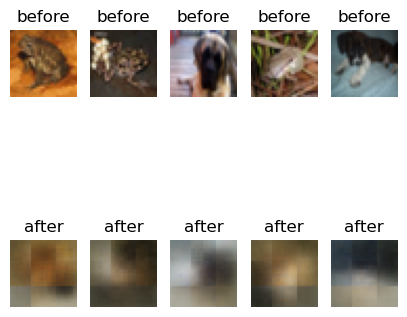

In [6]:
num_images = 5
indices = random.sample(range(len(dl_test.dataset)), num_images)

orig_imgs = []
rec_imgs = []

for idx in indices:
    img, label = dl_test.dataset[idx]
    orig_img = img
    orig_img = orig_img * torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1) + torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1)
    orig_img = orig_img[0].permute(1, 2, 0)
    orig_imgs.append(orig_img)

    device = next(encoder.parameters()).device
    img = img.to(device)
    img = img.unsqueeze(0)
    encoded_img = encoder(img)
    encoded_img = encoded_img.view(encoded_img.size(0), -1)
    r_img = decoder(encoded_img)
    r_img = r_img.to('cpu')
    r_img = r_img * torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1) + torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1)
    r_img = r_img[0].permute(1, 2, 0)
    rec_imgs.append(r_img)
    
plt.figure(figsize=(5, 5))
for i, (a, b) in enumerate(zip(orig_imgs, rec_imgs)):
    plt_axis = plt.subplot(2, num_images, i + 1)
    plt.title('before')
    plt.imshow(a.cpu().numpy(), cmap='gray')
    plt.axis('off')
    b = b.detach().cpu().numpy()
    plt_axis = plt.subplot(2, num_images, i + 1 + num_images)
    plt.title('after')
    plt.imshow(b, cmap='gray')
    plt.axis('off')

plt.show()

#### Initialize classifier (use pre-trained encoder)

In [7]:

# test acc 56.8 - 20 epoch, lr=0.001, dropout=0.15
classifier = clf.Classifier(hidden_layers=[1024, 512, 256, 128, 64], dropout_rate=0.15).to(device)

#classifier = clf.Classifier(hidden_layers=[512, 128, 64], dropout_rate=0.15).to(device)
#classifier = clf.Classifier(hidden_layers=[1024, 512, 256, 128, 64], dropout_rate=0.2).to(device)

#### Train Classifier (fully-supervised training + freeze encoder)

In [8]:
hyperparams = {
    'loss_fn': torch.nn.CrossEntropyLoss(),
    'optimizer' : optim.Adam,
    #'optimizer' : optim.SGD,
    #'weight_decay' : 1e-5,
    'weight_decay' : 0,
    'learning_rate': 0.001, # adam 0.001   
    'num_epochs': 40,            
}

freeze_encoder = True

trainer = clf.clfTrainer(classifier, encoder, dl_train, dl_test, hyperparams, freeze_encoder, device)
train_acc, test_acc = trainer.trainClassifier()

Epoch 1:
    Train Loss: 1.9311, Train Accuracy: 30.38%
    Test Loss: 1.8373, Test Accuracy: 33.28%
Epoch 2:
    Train Loss: 1.8490, Train Accuracy: 33.29%
    Test Loss: 1.8006, Test Accuracy: 35.46%
Epoch 3:
    Train Loss: 1.8278, Train Accuracy: 33.99%
    Test Loss: 1.7892, Test Accuracy: 35.45%


KeyboardInterrupt: 

#### Test Classifier on Validation

In [15]:
val_loss, val_accuracy = trainer.evalClassifier(dl_val)

Validation Loss: 2.5487, Validation Accuracy: 55.88%


#### plot downstream *classification* accuracy over - training, validation, test sets

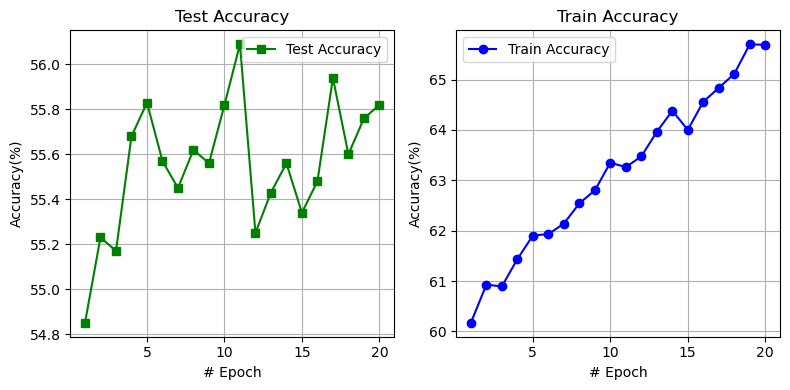

In [16]:
# Plot Train Accuracy over Epochs
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, marker='o', linestyle='-', color='b', label='Train Accuracy')
plt.title("Train Accuracy")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy(%)")
plt.grid(True)
plt.legend()

# Plot Test Loss over Iterations
plt.subplot(1, 2, 1)
plt.plot(range(1, len(test_acc) + 1), test_acc, marker='s', linestyle='-', color='g', label='Test Accuracy')
plt.title("Test Accuracy")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy(%)")
plt.grid(True)
plt.legend()

# Display the graphs
plt.tight_layout()
plt.show()


#### hyperparameter tunning

In [14]:
'''
piazza - can explain in words what we did in order to tune.
'''

'\npiazza - can explain in words what we did in order to tune.\n'

## 1.2.2

#### Initialize classifier + encoder

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder2 = autoencoders.Encoder_cifar10().to(device)
classifier2 = clf.Classifier().to(device)

#### Train encoder & classifier JOINTLY

In [10]:
hyperparams = {
    'loss_fn': torch.nn.CrossEntropyLoss(),
    'optimizer' : optim.Adam,
    'weight_decay' : 0.0,
    'learning_rate': 0.001,  
    'num_epochs': 5,            
}
freeze_encoder = False

trainer = clf.clfTrainer(classifier2, encoder2, dl_train, dl_test,
                                 hyperparams, freeze_encoder, device)
train_acc, test_acc = trainer.trainClassifier()

Epoch 1:
    Train Loss: 0.2231, Train Accuracy: 92.32%
    Test Loss: 0.7343, Test Accuracy: 78.62%
Epoch 2:
    Train Loss: 0.1308, Train Accuracy: 95.57%
    Test Loss: 0.7844, Test Accuracy: 79.18%
Epoch 3:
    Train Loss: 0.0953, Train Accuracy: 96.82%
    Test Loss: 0.8636, Test Accuracy: 78.78%
Epoch 4:
    Train Loss: 0.0800, Train Accuracy: 97.31%
    Test Loss: 0.8835, Test Accuracy: 79.00%
Epoch 5:
    Train Loss: 0.0655, Train Accuracy: 97.79%
    Test Loss: 0.8985, Test Accuracy: 79.58%


#### view train and test accuracy

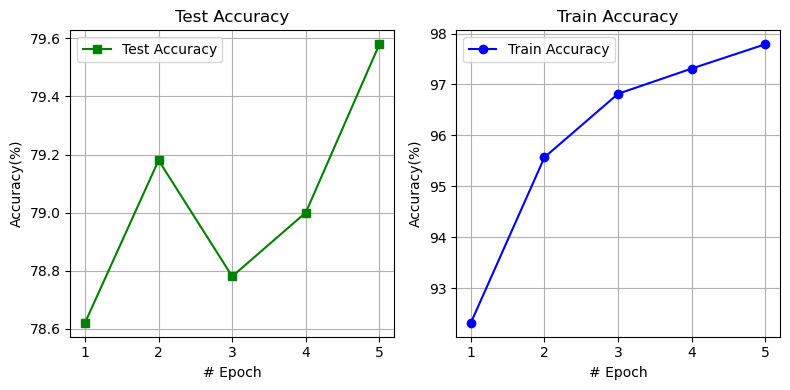

In [12]:

# Plot Train Accuracy over Epochs
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, marker='o', linestyle='-', color='b', label='Train Accuracy')
plt.title("Train Accuracy")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy(%)")
plt.grid(True)
plt.legend()

# Plot Test Loss over Iterations
plt.subplot(1, 2, 1)
plt.plot(range(1, len(test_acc) + 1), test_acc, marker='s', linestyle='-', color='g', label='Test Accuracy')
plt.title("Test Accuracy")
plt.xlabel("# Epoch")
plt.ylabel("Accuracy(%)")
plt.grid(True)
plt.legend()

# Display the graphs
plt.tight_layout()
plt.show()

#### Evaluate on validation set

In [13]:
val_loss, val_accuracy = trainer.evalClassifier(dl_val)

Validation Loss: 0.9112, Validation Accuracy: 79.10%


## 1.2.3

#### Prepare data

torch.Size([256, 3, 32, 32])


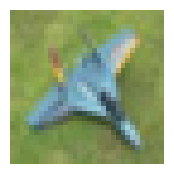

In [7]:
def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

freeze_seeds(42)

# normalize data 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


dataset_path = '/datasets/cv_datasets/data'
batch_size = 256

# Load CIFAR10 from the given path
ds_train = datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform)
ds_validation = datasets.CIFAR10(root=dataset_path, train=False, download=False, transform=transform)

# dataset split: 
# train + test (during training)
# validation

# Split  80% train  20% test
train_size = int(0.8 * len(ds_train))  
test_size = len(ds_train) - train_size  
ds_train, ds_test = random_split(ds_train, [train_size, test_size])

# DataLoaders
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_validation, batch_size=batch_size, shuffle=True)


# Example - [batch_size, 3, 32, 32]
for image, label in dl_train:
    print(image.shape)
    plt.figure(figsize=(2, 2)) 
    # Denormalize the image befor plt.imshow
    image = image * torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1) + torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1)
    img = image[0].permute(1, 2, 0)
    plt.imshow(img.cpu().numpy()) 
    plt.axis('off')  
    plt.show()

    break

#### Initialize encoder

In [8]:
import constrasive

# start with using the encoder structure from 1.2.1 , 1.2.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = autoencoders.Encoder_cifar10().to(device)


# Example Usage
#model = constrasive.ResNet18Encoder(128, False, device)
#x = torch.randn(4, 3, 32, 32)  # Example CIFAR-10 input
#output = model(x)
#print(output.shape)

#model = constrasive.ResNet18Encoder().to(device)
#model = constrasive.SimCLREncoder(hidden_dim=128).to(device)
#model = constrasive.Encoder_cifar10().to(device)



#### Pair dataloaders for contrastive training

In [9]:

img_size = 32

transform1 = transforms.Compose([
    transforms.RandomResizedCrop(32),
    #transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    #transforms.RandomGrayscale(p=0.6),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])


batch_size = 256  #was 64->32->256 
# dataset that return pairs 
# instead of (img,label) returns (view1, view2, label)
pair_ds_train = constrasive.PairDataset(base_dataset=ds_train, transform=transform1)

# Split  80% train  20% test
train_size = int(0.8 * len(pair_ds_train))  
test_size = len(pair_ds_train) - train_size  
pair_ds_train, pair_ds_test = random_split(pair_ds_train, [train_size, test_size])

# DataLoaders
pair_dl_train = DataLoader(pair_ds_train, batch_size=batch_size, shuffle=True)
pair_dl_test = DataLoader(pair_ds_test, batch_size=batch_size, shuffle=True)


#### Pair example 

/home/kerenmizrahi/miniconda3/envs/cs236781-hw/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


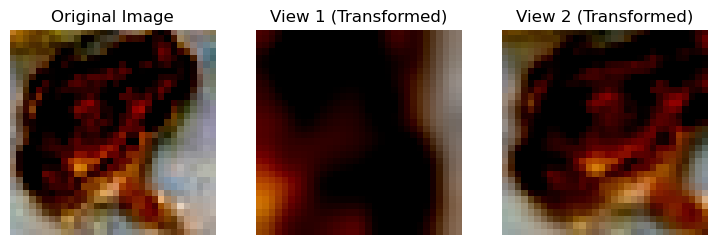

In [10]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Get the exact same original image
original_img, label = ds_train[25]  # Fetch the first image from the base dataset

# Apply the transformations manually to get two views of the same image
view1 = transform1(original_img)  
view2 = transform1(original_img)  

# Function to denormalize images
def denormalize(tensor):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    return (tensor * std + mean).clamp(0, 1)  # Reverse normalization and clip to [0,1]

# Convert images to numpy format
original_img = original_img.permute(1, 2, 0).numpy()  # Convert CHW to HWC
view1 = denormalize(view1).permute(1, 2, 0).numpy()  # Apply denormalization
view2 = denormalize(view2).permute(1, 2, 0).numpy()

# Plot all three images: Original, View 1, and View 2
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

ax[0].imshow(np.clip(original_img, 0, 1))  # Ensure valid range
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(view1)
ax[1].set_title("View 1 (Transformed)")
ax[1].axis("off")

ax[2].imshow(view2)
ax[2].set_title("View 2 (Transformed)")
ax[2].axis("off")

plt.show()

#### Train encoder (constrastive) 

In [11]:
loss_fn = constrasive.NTXentLoss(tmp=0.25)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
#optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
num_epochs = 5

constrasive.contrastive_train( model, pair_dl_train, pair_dl_test, loss_fn, optimizer, num_epochs, device)
#constrasive.contrastive_train( model, pair_dl_train, pair_dl_test, loss_fn, optimizer, num_epochs, device)

Epoch 1:
    train Contrastive Loss: 100000000.5120
    test Contrastive Loss: 100000000.0000
Epoch 2:
    train Contrastive Loss: 100000000.0000
    test Contrastive Loss: 100000000.0000
Epoch 3:
    train Contrastive Loss: 100000000.0000
    test Contrastive Loss: 100000000.0000
Epoch 4:
    train Contrastive Loss: 100000000.0000
    test Contrastive Loss: 100000000.0000
Epoch 5:
    train Contrastive Loss: 100000000.0000
    test Contrastive Loss: 100000000.0000


#### Print t-sne

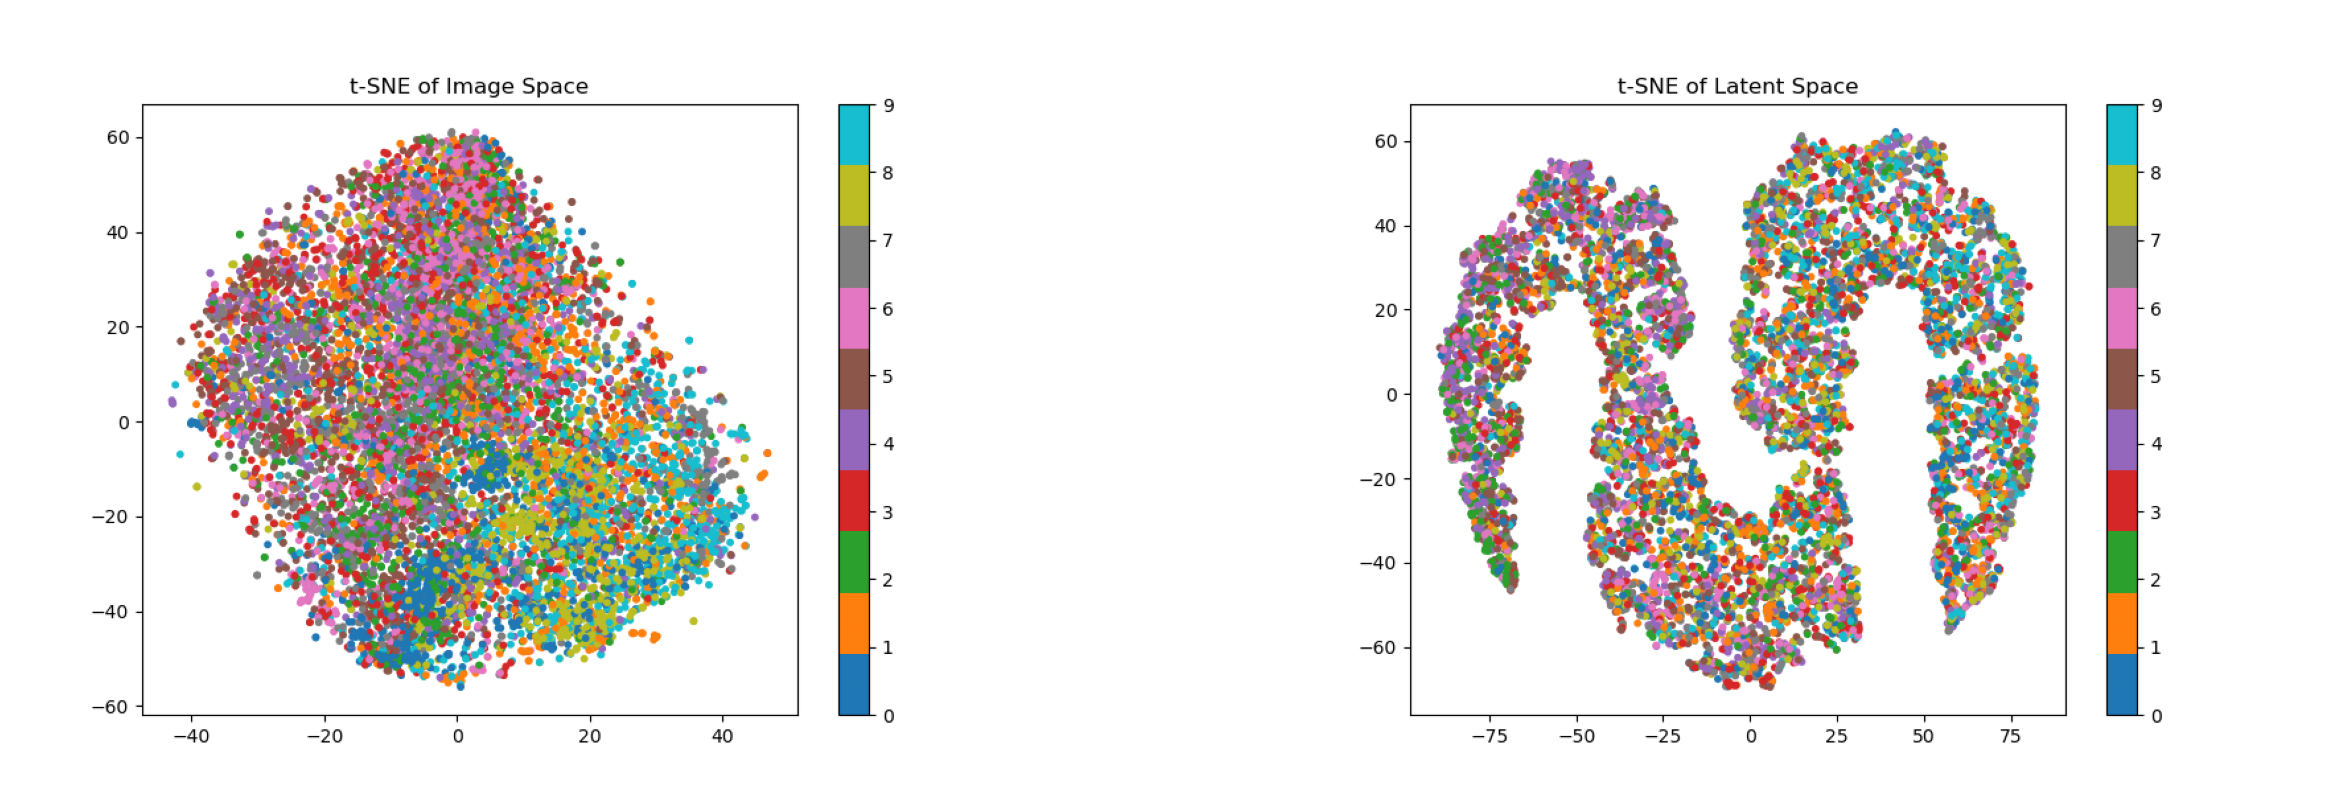

In [10]:
import matplotlib.image as mpimg

plot_tsne(model, dl_test, "CIFAR10", device)

orig = 'CIFAR10/image_tsne.png'
latent = 'CIFAR10/latent_tsne.png'

plt.figure(figsize=(30, 30))

img = mpimg.imread(orig)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')  

img = mpimg.imread(latent)
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.axis('off') 

plt.show()

#### Initialize classifier (use pre-trained encoder)

In [ ]:
import CIFAR10.classifier as clf

# test acc 56.8 - 20 epoch, lr=0.001
classifier = clf.Classifier(hidden_layers=[1024, 512, 256, 128, 64], dropout_rate=0.15).to(device)
#classifier = clf.Classifier(hidden_layers=[1024, 512, 256, 128, 64], dropout_rate=0.2).to(device)

#### Train Classifier (fully-supervised training + freeze encoder)

In [ ]:
hyperparams = {
    'loss_fn': torch.nn.CrossEntropyLoss(),
    'optimizer' : optim.Adam,    
    'learning_rate': 0.0001,   
    'num_epochs': 10,            
}

freeze_encoder = True

trainer = clf.clfTrainer(classifier, encoder, dl_train, dl_test,
                                 hyperparams, freeze_encoder, device)
train_acc, test_acc = trainer.trainClassifier()